In [1]:
# A partir de ahora, todos los imports se pondrán en la primera celda
import numpy as np
import pandas as pd

from plotnine import aes, geom_point, scale_color_manual, \
                     ggplot, geom_smooth, labs, theme, element_line, element_rect, scale_fill_manual, scale_fill_manual, \
                     geom_line, geom_tile, geom_text, scale_fill_gradient, scale_y_discrete

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import zipfile
import requests
import io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Para no tener que repetir todo el rato lo mismo se procesa el dataframe en un archivo
%run config.py
from config import df

In [3]:
# creamos una varible numérica para usarla como variable respuesta. Female = 0, Male = 10

df['gender_num'] = df['gender'].map({'Male': 1, 'Female': 0})

### Regresión Logística

En los modelos de las lecciones anteriores la variable a predecir era la altura. La altura es una magnitud continua, pero, ¿qué pasaría si lo que se pretende es predecir es una variable categórica como el sexo?

En principio, podríamos tratar de usar una regresión lineal. Por ejemplo:

$sexo = \beta_0 + \beta_1 \cdot peso$

En el siguiente gráfico representamos el dataset y la recta de regresión.

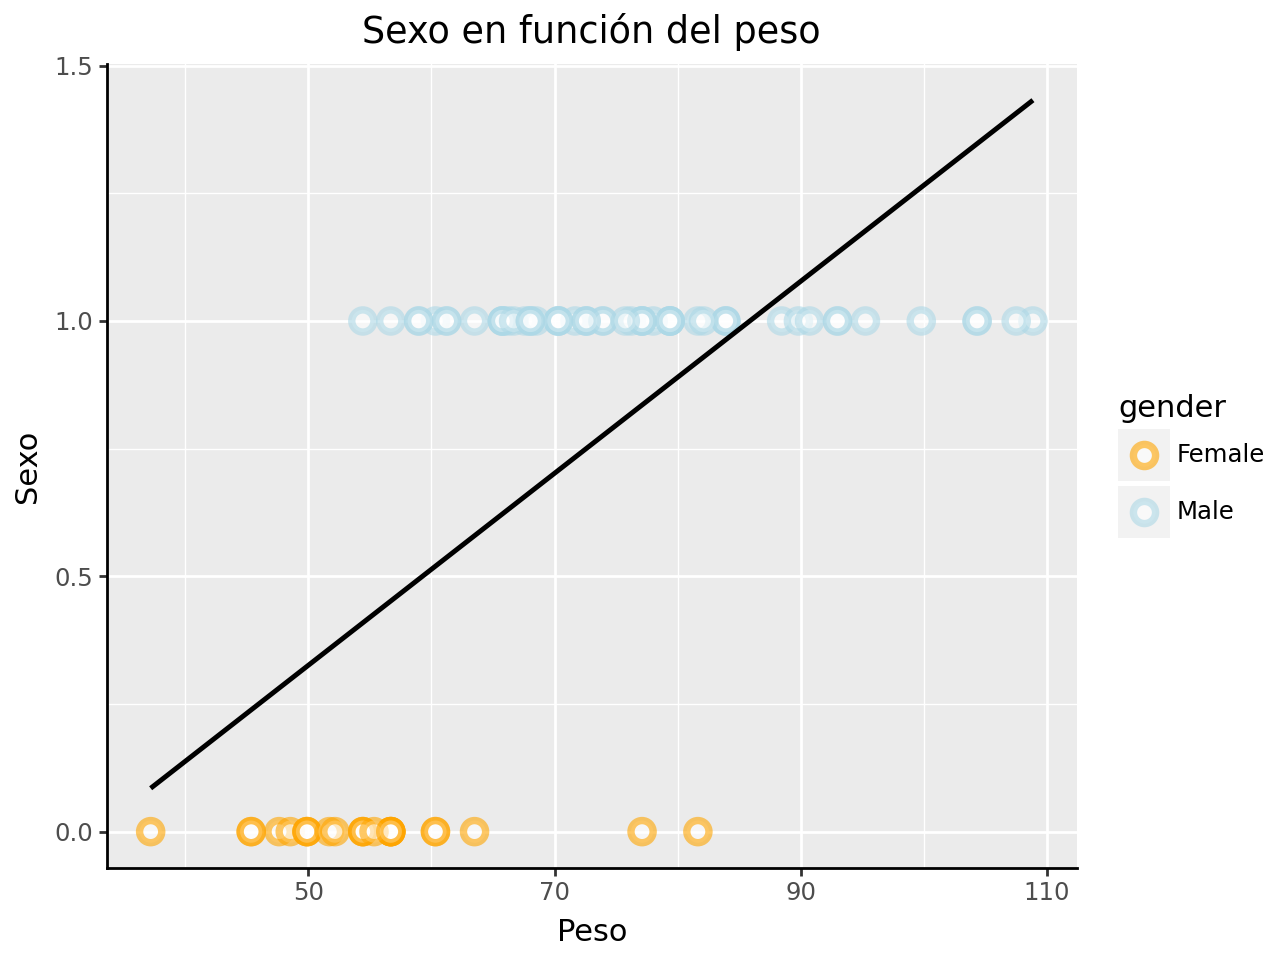

In [4]:

plot = (
    ggplot(df, aes(x='weight', y='gender_num', color='gender'))
    + geom_point(shape='o', size=3, fill='white', stroke=1.5, alpha=0.6)
    + geom_smooth(method='lm', color='black', se=False)
    + scale_color_manual(values={'Male': 'lightblue', 'Female': 'orange'}) +
    labs(title='Sexo en función del peso', x='Peso', y='Sexo') +
    theme(
        axis_line_x=element_line(color='black', size=1),
        axis_line_y=element_line(color='black', size=1),
    )
)
plot


Vemos que modelar con regresión lineal una variable dependiente categórica no es lo más adecuado. Las predcciones no serán 0 ó 1 sino valores continuos. Así que tendremos predicciones con valores como 0.5, 1.5 ó -0.6. ¿Qué significa eso? ¿Qué es 1.5? ¿Es hombre o es mujer? Lo probable es que sea hombre. Una cosa que podemos hacer es estableces que si la predicción es mayor a 0.5 entonces es hombre y si es menor a 0.5 entonces es mujer. De todas formas, eso no va a funcionar muy bien. Por ejemplo, la pendiente, que  mide la relación entre el sexo y la altura no va a ser interpretable.

El problema se produce porque la regresión lineal precice valores entre $-\infty$ y $+\infty$, pero el sexo sólo puede tomar dos valores: hombre (1) o mujer (0). Por lo tanto, la regresión lineal no es un buen modelo para este tipo de problemas.

De momento, lo único que conocemos es la regresión lineal. Supongamos que queremos seguir utilizándola. Para ello, nos hacemos la siguiente pregunta:

¿Y si en lugar de predecir si es hombre o mujer, predecimos la probabilidad de que sea hombre? En este caso, la variable dependiente sería la probabilidad de que el sexo sea hombre. La probabilidad de que el sexo sea hombre es un número entre 0 y 1. Por lo tanto, podemos usar una función que transforme los valores de la regresión lineal en valores entre 0 y 1. Una función que cumple con esto es la función sigmoide.

La función sigmoide tiene la siguiente definición matemática:

$f(x) = \frac{1}{1 + e^{-x}}$

Gráficamente:

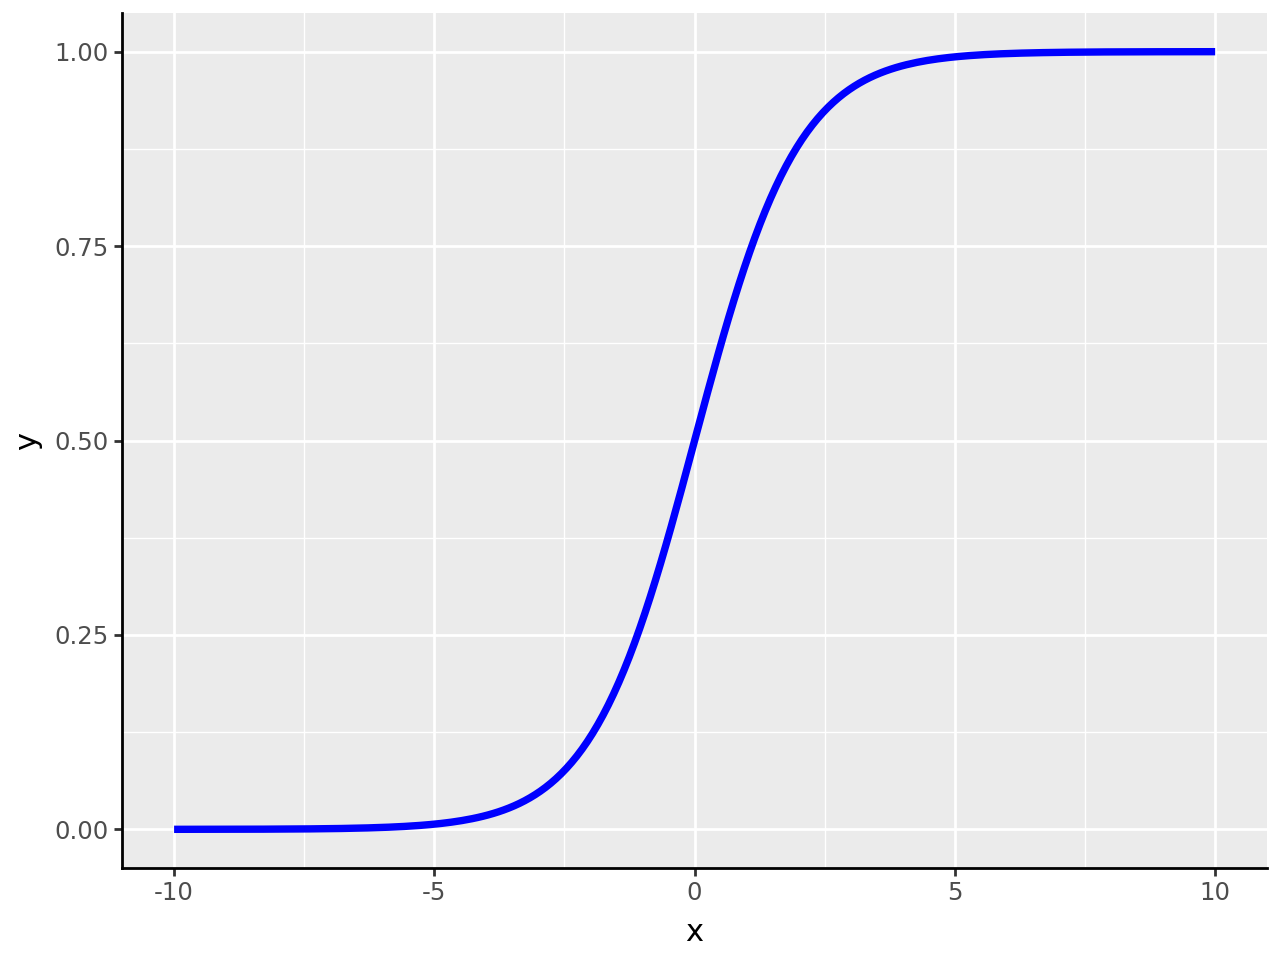

In [5]:
# Definir la función sigmoide
sigmoid = lambda x: 1 / (1 + np.exp(-x))

# Crear un rango de valores x
x = np.linspace(-10, 10, 200)

# Calcular y para la función sigmoide
y = sigmoid(x)

# Crear DataFrame para plotnine
df2 = pd.DataFrame({'x': x, 'y': y})

# Crear gráfico con plotnine
plot = (
    ggplot(df2, aes(x='x', y='y'))
    + geom_line(color='blue', size=1.5)
    + theme(
        axis_line_x=element_line(color='black', size=1),
        axis_line_y=element_line(color='black', size=1),
    )
)

plot


La función sigmoide tiene una forma de S, de ahí su nombre. La función sigmoide toma valores entre 0 y 1. Cuando $x$ es muy grande, la función sigmoide tiende a 1. Cuando $x$ es muy pequeño, la función sigmoide tiende a 0. Cuando $x$ es 0, la función sigmoide vale 0.5.

Bien, ya tenemos una función que oscila entre cero y uno. ¿Cómo la usamos? Pues de esta forma:

$P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 )}}$

Es decir, que la probabilidad de que el sexo sea hombre es igual a la función sigmoide de la regresión lineal. En este caso, $X_1$ es el peso e $Y$ es el sexo. La variable dependiente es la probabilidad de que el sexo sea hombre. La variable independiente es el peso. $\beta_0$ y $\beta_1$ son los parámetros del modelo.

El problema es que eso no es una regresión lineal y no sabemos cómo calcular los parámetros del modelo. La función sigmoide no es lineal, así que no podemos usar la regresión lineal para calcular los parámetros del modelo. Lo que podemos hacer es intentar "linealizar" la ecuación. Con un poco de destreza matemática, podemos llegar a la siguiente ecuación:

$\log\left(\frac{P(Y=1)}{1 - P(Y=1)}\right) = \beta_0 + \beta_1 X_1$

A esa función se le llama logit. La función logit es la inversa de la función sigmoide. La función logit toma valores entre $-\infty$ y $+\infty$. El logit es lineal en los parámetros del modelo y tiene una interesante interpretación estadística que no vamos a discutir aquí. También la tienen los parámetros del modelo y tampoco lo abordamos. Cuando la probabilidad de que el sexo sea hombre es 0.5, el logit vale 0. Cuando la probabilidad de que el sexo sea hombre es 1, el logit tiende a $+\infty$. Cuando la probabilidad de que el sexo sea hombre es 0, el logit tiende a $-\infty$.

En definitiva, la regresión logística es un modelo de regresión que permite predecir una variable categórica dicotómica. La regresión logística pertenece a la familia de modelos lineales generalizados (GLM). Esta familia permite usar la regresión lineal transformado la variable dependiente con una función de enlace. En el caso de la regresión logística, la función de enlace es la función logit. Aunque la interpretación de la función logit sea complicada se puede aplicar su inversa (la función sigmoide) para obtener la probabilidad de que el sexo sea hombre. Y eso es fácilmente interpretable.

### Función de pérdida de la regresión logística (opcional)

Podríamos tratar de usar la función de mínimos cuadrados como función de pérdida. Recordemos la forma de esa función:

$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

Donde $y_i$ es el valor real y $\hat{y}_i$ es el valor predicho. En este caso, $y_i$, $\hat{y}_i$ pueden ser 0 o 1. $\hat{y}_i$ será 1 cuando $\hat{p}_i \ge 0.5$ y 0 en caso contrario. 

El $MSE$ no es adecuado en la regresión logística porque el algoritmo de descenso de gradiente lo que hace es modificar ligeramente los parámetros en la dirección opuesta del gradiente. El problema es que, como los valores estimados del modelo solo son 0 ó 1, los cambios de valores serán o nulos o muy bruscos y eso no es adecuado para el descenso de gradiente.

En su lugar se utiliza la función de pérdida de entropía cruzada también llamada negativo del logaritmo de la función de verosimilitud. Dados unos coeficientes del modelo, la probabilidad de un solo punto se puede definir:

$P(y_i = 1) = \hat{p_i}^{y_i} \cdot (1-\hat{p_i})^{1-y_i}$

Esta fórmula parece complicada, pero es una forma compacta de escribir la probabilidad definida en el modelo. Ya que cuando $y_i = 1$ la fórmula se reduce a:

$P(y_i = 1) = \hat{p_i}$

Y cuando $y_i = 0$ se reduce a:

$P(y_i = 0) = 1 - \hat{p_i}$

La probabilidad de todos los puntos en conjunto se denomina función de verosimilitud y se define como el producto de las probabilidades individuales:

$L(\beta) = \prod_{i=1}^N \hat{p}_i^{y_i} (1-\hat{p}_i)^{1-y_i}$

Nos interesa maximizar la función de verosimilitud respecto a los parámetros del modelo. Pero multiplicar probabilidades que están entre 0 y 1 va a dar lugar a números muy pequeños que no se van a poder manejar adecuadamente en una computadora. Por lo que es mejor trabajar con el logaritmo de la función de verosimilitud. El logaritmo cambia el valor de la función pero no así el punto en el que se maximiza. Esto es así porque es una función monótona creciente. La ventaja de tomar logaritmos es que el producto se convierte en sumas y se eliminan los problemas de aproximación numéricos. Por lo que la función de verosimilitud se puede escribir como: 

$\ell(\beta) = \log L(\beta) = \sum_{i=1}^N \left[ y_i \log(\hat{p}_i) + (1-y_i)\log(1-\hat{p}_i) \right]$

El último paso es convertir el problema de maximización en uno de minimización. Para ello, se multiplica por -1. De esta forma, la función de pérdida de entropía cruzada se define como:

$\text{Log-loss} = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(\hat{p}_i) + (1-y_i)\log(1-\hat{p}_i) \right]$


### Ejemplo de regresión logística

Vamos a construir un modelo para predecir el sexo a partir del peso y de la altura. Como vimos en el primer apartado de esta lección, podríamos usar un modelo de regresión lineal. Sin embargo, este modelo no es adecuado, ya que regresión lineal predice valores entre $-\infty$ y $+\infty$, pero el sexo es categórico ($0 =$ `Female` y $1=$ `Male`). En cualquier caso, podemos tratar de utilizarlo para ver qué resultados produce. Se predecirá `Male` cuando el modelo dé un valor $\ge 0.5$ y `Female`en caso contrario. La ecuación de la regresión lineal sería:

$sexo = \beta_0 + \beta_1 \cdot peso + \beta_2 \cdot altura$

En la siguiente celda se muestra el proceso. Para evaluar el modelo se utiliza una métrica conocida con el nombre de exactitud (`accuracy`). La exactitud es la proporción de predicciones correctas respecto al total de predicciones.

In [6]:
X = df[['weight', 'height']]  # Variables predictoras
y = df['gender_num']

lineal_model = LinearRegression()
lineal_model.fit(X, y)

y_pred_continuous = lineal_model.predict(X)

# Convertir predicciones a etiquetas binarias
y_pred_binary = (y_pred_continuous >= 0.5).astype(int)  # 1 = male, 0 = female

# Calcular exactitud
accuracy = accuracy_score(y, y_pred_binary)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.90


Vemos que el modelo es capaz de predecir el sexo con una exactitud del 90%. No está nada mal para un modelo que no es adecuado.

Hagamos el mismo ejercicio pero usando un modelo de regresión logística. En este caso, la ecuación del modelo es:

$\log\left(\frac{P(Gender=Male)}{P(Gender=Female)}\right) = \beta_0 + \beta_1 \cdot peso + \beta_2 \cdot altura$


In [7]:
logistic_model = LogisticRegression()
logistic_model.fit(X, y)

y_pred_continuous = logistic_model.predict(X)

# Calcular exactitud
accuracy = accuracy_score(y, y_pred_binary)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.90


Los resultados son sorprendentes. Para este `dataset` el modelo de regresión logística es capaz de predecir el sexo con una exactitud del 90%, que es igual que el resultado alcanzado con la regresión lineal. Esto nos lleva a considerar la frase acuñada por el estadístico [G. Pelham Box](https://es.wikipedia.org/wiki/George_Edward_Pelham_Box): 

> *Essentially, all models are wrong, but some are useful.*

En cualquier caso, aquí habría que haber tenido en cuenta la posibilidad de sobreajuste comentada en la lección anterior. Para ello, tendríamos que haber dividido el `dataset` en dos partes: una para entrenar el modelo y otra para evaluar su rendimiento. En este ejercicio no se ha hecho porque tenemos pocos datos. Esto se hará en el siguiente apartado.

Podemos ver gráficamente la clasificación realizada y que la frontera de decisión que separa una clase de otra es lineal. Es decir, la regresión logística separa las clases linealmente.

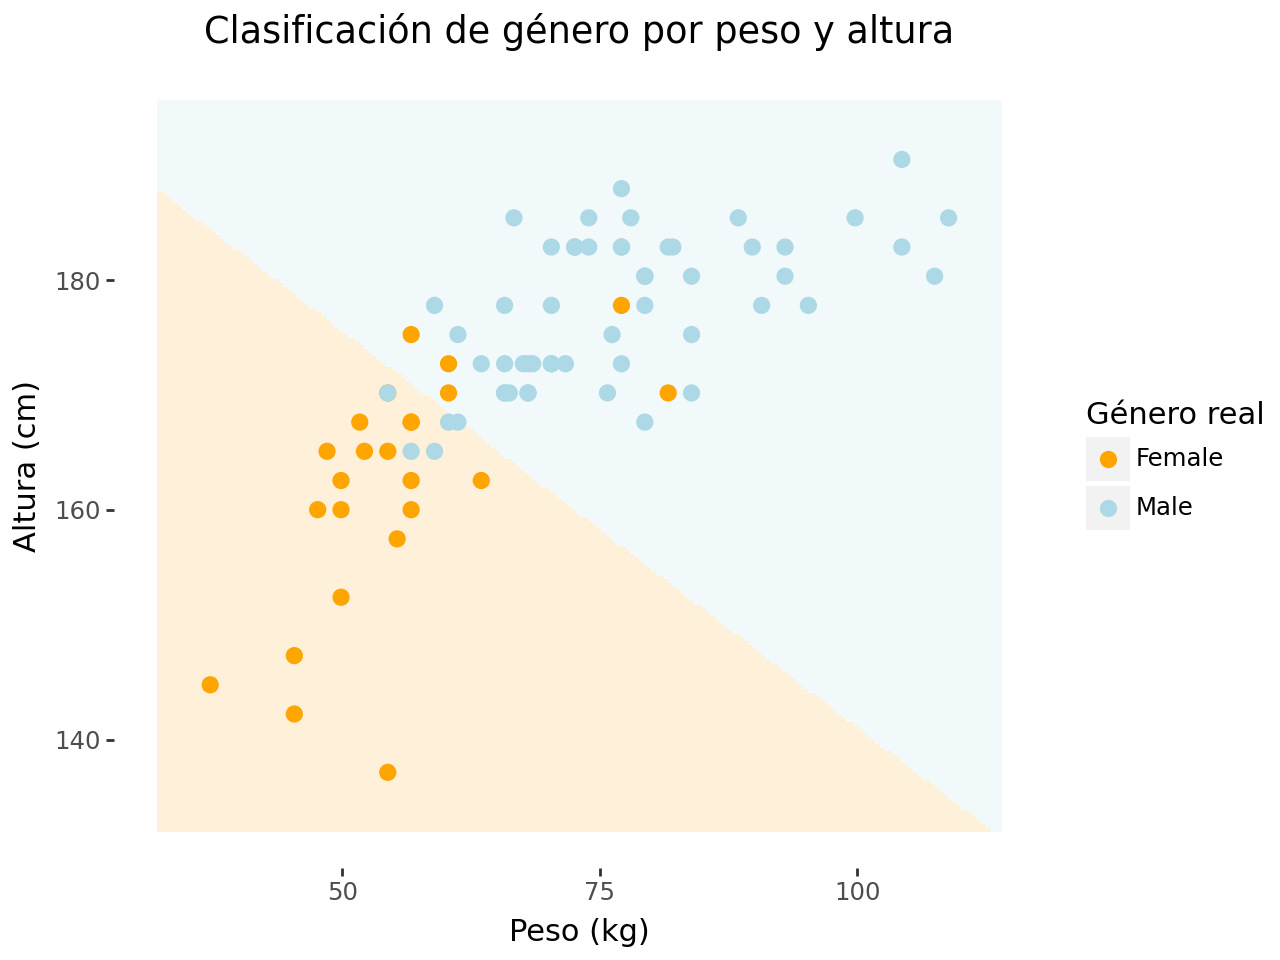

In [8]:
weight_range = np.linspace(df['weight'].min()-5, df['weight'].max()+5, 200)
height_range = np.linspace(df['height'].min()-5, df['height'].max()+5, 200)
W, H = np.meshgrid(weight_range, height_range)

# Predecir clases y probabilidades
mesh_points = np.c_[W.ravel(), H.ravel()]
mesh_points = pd.DataFrame(mesh_points, columns=['weight', 'height'])
probs = logistic_model.predict_proba(mesh_points)[:, 1]

df_mesh = pd.DataFrame({
    'weight': W.ravel(),
    'height': H.ravel(),
    'prob_male': probs,
    'gender_pred': logistic_model.predict(mesh_points)
})

color_map = {'Male': 'lightblue', 'Female': 'orange'}

(ggplot()
 + geom_tile(df_mesh, aes(x='weight', y='height', fill='factor(gender_pred)'), alpha=0.15, show_legend=False)
 + geom_point(df, aes(x='weight', y='height', color='gender'), size=2.5)
 + scale_fill_manual(values=['orange', 'lightblue'])
 + scale_color_manual(values=color_map)
 + labs(title='Clasificación de género por peso y altura',
        x='Peso (kg)', 
        y='Altura (cm)',
        color='Género real')
) + theme(
    panel_background=element_rect(fill='white'),
    plot_background=element_rect(fill='white')
)


# Clasificación de imágenes con regresión logística

En este apartado se va a usar un `dataset` de imágenes de dígitos escritos a mano. El `dataset` se llama [MNIST](http://yann.lecun.com/exdb/mnist/) y contiene 70.000 imágenes de dígitos escritos a mano. Cada imagen tiene un tamaño de 28x28 píxeles y está en escala de grises. El `dataset` está dividido en dos partes: 60.000 imágenes para entrenar el modelo y 10.000 imágenes para evaluar su rendimiento. El `dataset` MNIST es considerado el "Hola Mundo" de la clasificación de imágenes. Las imágenes de los números se obtuvieron de los formularios de la oficina de correos de Estados Unidos. En la siguiente celda se descarga el `dataset` y se carga en memoria.

In [9]:
# URLs de los archivos
train_url = "https://github.com/phoebetronic/mnist/raw/main/mnist_train.csv.zip"
test_url = "https://github.com/phoebetronic/mnist/raw/main/mnist_test.csv.zip"

# Función para descargar y extraer CSV desde ZIP
def download_and_extract_csv(url):
    print(f"Descargando desde {url}...")
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        for name in zip_ref.namelist():
            with zip_ref.open(name) as f:
                print(f"Extrayendo {name}")
                # Cargar CSV como NumPy
                data = np.loadtxt(f, delimiter=",", dtype=np.uint8)
                return data

# Descargar y cargar los datos
train_data = download_and_extract_csv(train_url)
test_data = download_and_extract_csv(test_url)


Descargando desde https://github.com/phoebetronic/mnist/raw/main/mnist_train.csv.zip...
Extrayendo mnist_train.csv
Descargando desde https://github.com/phoebetronic/mnist/raw/main/mnist_test.csv.zip...
Extrayendo mnist_test.csv


Mostramos los `datasets`. Observamos que cada imagen está en una lista y que el primer valor de cada imagen tiene el número que representa. El resto de valores 784 valores van del 0 al 255, y representan el color de cada pixel. El valor 0 representa el color negro y el valor 255 representa el color blanco. Por lo tanto, el modelo trenda 785 parámetros (uno para cada punto de imagen + el intercepto).

In [10]:
train_data, test_data

(array([[5, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [5, 0, 0, ..., 0, 0, 0],
        [6, 0, 0, ..., 0, 0, 0],
        [8, 0, 0, ..., 0, 0, 0]], shape=(60000, 785), dtype=uint8),
 array([[7, 0, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [4, 0, 0, ..., 0, 0, 0],
        [5, 0, 0, ..., 0, 0, 0],
        [6, 0, 0, ..., 0, 0, 0]], shape=(10000, 785), dtype=uint8))

Separamos las `labels` de las imágenes.

In [11]:
train_y = train_data[:, 0]  # Primera columna como etiquetas
train_X = train_data[:, 1:]  # Resto como características
test_y = test_data[:, 0]  # Primera columna como etiquetas
test_X = test_data[:, 1:]  # Resto como características


El entrenamiento funciona mejor si se normalizan las imágenes para que cada color esté entre 0 y 1.

In [12]:
train_X = train_X / 255.0  # Normalizar etiquetas entre 0 y 1
test_X = test_X / 255.0  # Normalizar características entre 0 y 1

Mostramos 5 imágenes aleatorias

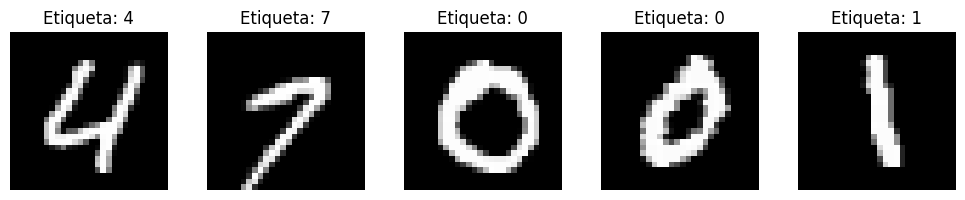

In [13]:
def show_number(labels, images, num_img=5):
    indexes = np.random.choice(df.shape[0], num_img, replace=False)
    img_sample = images[indexes].reshape(-1, 28, 28)
    img_labels = labels[indexes]

    plt.figure(figsize=(num_img * 2, 2))
    for i in range(num_img):
        plt.subplot(1, num_img, i + 1)
        plt.imshow(img_sample[i], cmap='gray')
        plt.title(f"Etiqueta: {int(img_labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
show_number(train_y, train_X, 5)

Ahora vamos a construir un modelo para predecir las imágenes. En este caso se trata de una clasificación de una variables categórica con 10 posibles valores (del 0 al 9). No podemos usar regresión logística ya que ésta sólo permite predecir 2 clases. Sin embargo, podemos usar una extensión de la regresión logística en la que en vez de la función Sigmoide se usa la función SoftMax, que permite estimar la probabilidad de más de una clase. Esto se hace en la siguiente celda. El parámetro `max_iter` controla el máximo número de iteraciones de algoritmo de descenso de gradiente. Para acelerar el proceso se debe fijar en un valor bajo aunque se perderá eficiencia. Para que tarde poco, aquí se ha dejado un número de iteraciones inadecuadamente bajo.

In [14]:
model = LogisticRegression(max_iter=10, solver='lbfgs')
model.fit(train_X, train_y)
y_pred = model.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.88


/home/surtich/projects/IA para desarrolladores/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 10 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Vemos que hemos alcanzado una exactitud bastante buena incluso aunque el modelo no haya convergido (es decir, que la función de pérdida hubiera seguido disminuyendo si aumentamos el número de iteraciones). Hay que considerar que ahora tenemos 10 clases frente a las dos de la clasificación binaria y que ésta se está calculando sobre los datos de test, que no han sido usados en el modelo. En la siguiente celda se muestra la matriz de confusión. La matriz de confusión es una tabla que muestra el número de aciertos y errores del modelo. En la diagonal principal están los aciertos y en el resto de la tabla están los errores. En filas están las clases reales y en columnas las clases predichas. 

In [15]:
cm = confusion_matrix(test_y, y_pred)
labels = range(0,10)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
df_cm

,0,1,2,3,4,5,6,7,8,9
0,955,0,4,4,0,4,6,1,6,0
1,0,1065,13,13,1,7,4,0,32,0
2,21,1,878,23,14,1,25,21,40,8
3,7,0,17,873,1,48,8,17,24,15
4,4,5,5,1,863,2,18,2,10,72
5,22,4,6,42,18,719,18,8,44,11
6,22,3,14,2,9,22,875,0,11,0
7,5,19,37,2,10,0,3,900,6,46
8,9,6,16,35,6,35,15,13,821,18
9,13,6,11,13,38,19,1,23,9,876


Lo podemos ver mejor gráficamente con un mapa de calor (`heatmap`) en el que sólo se muestran los errores de predicción:

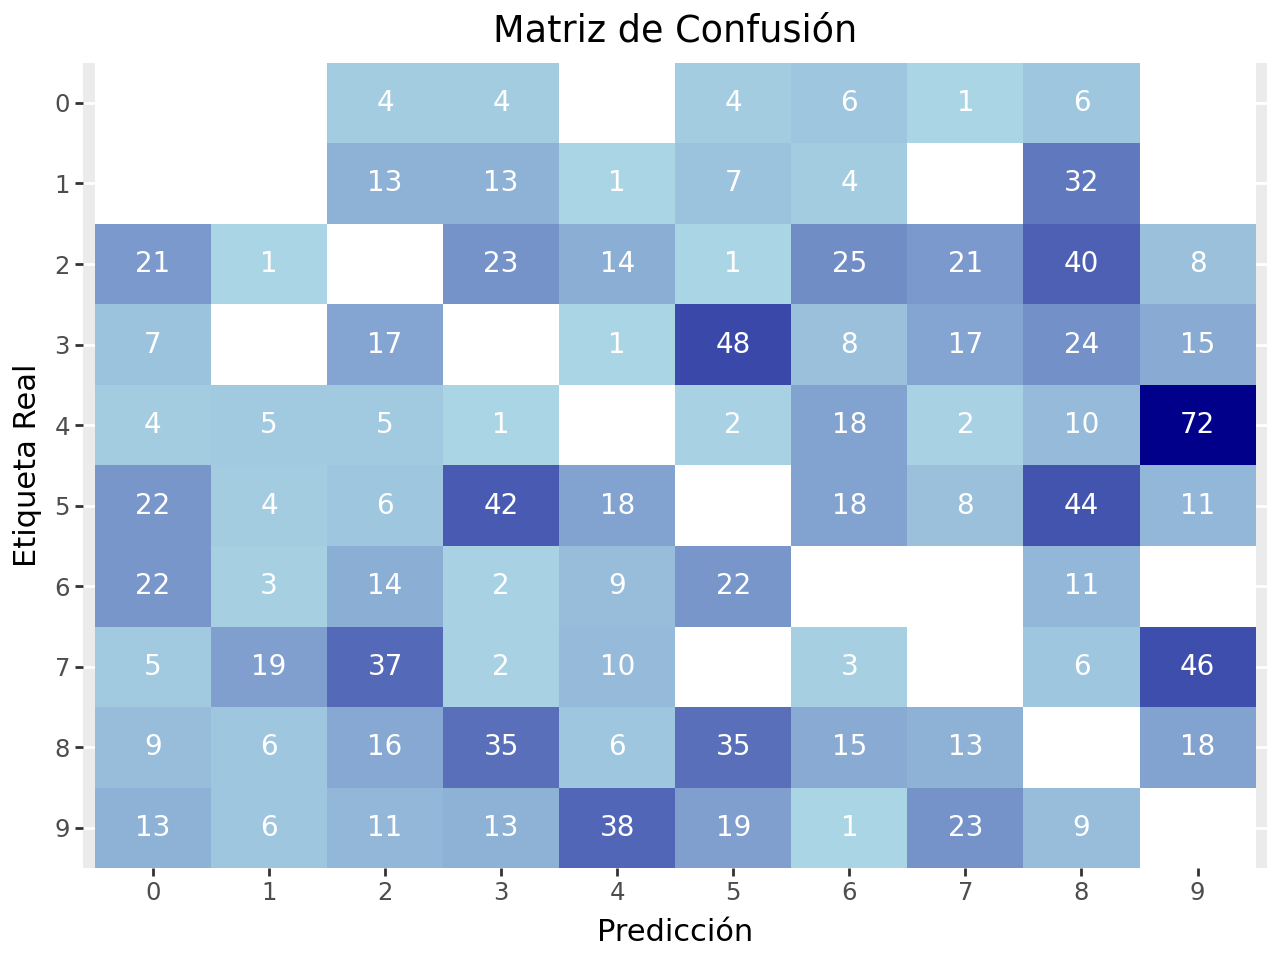

In [16]:
df_cm_long = df_cm.reset_index().melt(id_vars='index')
df_cm_long.columns = ['Actual', 'Predicted', 'Count']

 # Convertir Actual a categoría con niveles invertidos para invertir eje y
df_cm_long['Actual'] = pd.Categorical(df_cm_long['Actual'], categories=labels[::-1], ordered=True)
df_cm_long['Predicted'] = pd.Categorical(df_cm_long['Predicted'], categories=labels, ordered=True)

# Poner a 0 la diagonal para el gradiente de color
diag_mask = df_cm_long['Actual'].astype(str) == df_cm_long['Predicted'].astype(str)
df_cm_long.loc[diag_mask, 'Count'] = 0

# Quitar ceros del texto para que no se muestren
df_cm_long['label_text'] = df_cm_long['Count'].apply(lambda x: '' if x == 0 else str(x))

# Dataframe sólo con ceros para el overlay blanco
df_zeros = df_cm_long[df_cm_long['Count'] == 0]

p = (ggplot(df_cm_long, aes(x='Predicted', y='Actual', fill='Count'))
         + geom_tile(aes(fill='Count'))
         # Overlay blanco para ceros
         + geom_tile(data=df_zeros, fill='white')
         + geom_text(aes(label='label_text'), color='white', size=10, show_legend=False)
         + scale_fill_gradient(low='lightblue', high='darkblue')
         + scale_y_discrete(expand=(0,0))
         + labs(title='Matriz de Confusión', x='Predicción', y='Etiqueta Real')
         + theme(
              legend_position='none',
         )
         )
p
